In [1]:
import rasterio
from rasterio.transform import rowcol
from pyproj import Transformer

In [20]:
hennepin = rasterio.open("output2.tif")
green = rasterio.open("ndvi_map.tif")


In [22]:
green.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 9967,
 'height': 6451,
 'count': 1,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(8.983152841195215e-05, 0.0, -93.69590110117751,
        0.0, -8.983152841195215e-05, 45.12911408595446)}

In [23]:
h_to_wgs84 = Transformer.from_crs(hennepin.crs, "EPSG:4326", always_xy=True)
h_from_wgs84 = Transformer.from_crs("EPSG:4326", hennepin.crs, always_xy=True)

g_to_wgs84 = Transformer.from_crs(green.crs, "EPSG:4326", always_xy=True)
g_from_wgs84 = Transformer.from_crs("EPSG:4326", green.crs, always_xy=True)

In [24]:
h_band = hennepin.read(1)
g_band = green.read(1)

First we define the bounding box, which is the same bounding box of the green space band.

Now we write some code that gets a random acre inside the bounding box.

In [25]:
import numpy as np

ACRE_EDGE_METERS = 63.6149353533
DEGREES_PER_METER = 8.983e-6

In [7]:
# Very green area: (np.float32(23.872145), np.float64(8.207601746116067)) OR 3668.7333532301463
# Very red area: (np.float32(0.0), np.float64(8.36240856826096)) OR 4282.99824673542

In [26]:
from rasterio.windows import Window

def generate_point():
    lat = np.random.uniform(
        green.bounds.bottom + ACRE_EDGE_METERS * DEGREES_PER_METER, 
        green.bounds.top
    )

    lon = np.random.uniform(
        green.bounds.left, 
        green.bounds.right - ACRE_EDGE_METERS * DEGREES_PER_METER
    )
    return lat, lon

def generate_window(region, from_wsg84, lon, lat):
    x, y = from_wsg84.transform(lon, lat)
    row_min, col_min = rowcol(region.transform, x, y)

    # Bottom right for green
    x, y = from_wsg84.transform(lon + ACRE_EDGE_METERS * DEGREES_PER_METER, lat - ACRE_EDGE_METERS * DEGREES_PER_METER)
    row_max, col_max = rowcol(region.transform, x, y)
    window = Window(col_off=col_min, row_off=row_min, width=col_max-col_min+1, height=row_max-row_min+1)

    return window

In [29]:
data = {
    "heat": [],
    "green": []
}

vals = 0

while vals < 5000:
    
    # Generate random coordinates
    lat, lon = generate_point()

    # Get windows
    green_window = generate_window(green, g_from_wgs84, lon, lat)
    heat_window = generate_window(hennepin, h_from_wgs84, lon, lat)

    green_data = green.read(1, window=green_window)
    heat_data = hennepin.read(1, window=heat_window)
    heat_data = np.nan_to_num(heat_data, nan=0.0, posinf=0.0, neginf=0.0)

    if not (np.isfinite(heat_data.sum()) and np.isfinite(green_data.sum())):
        print("GOT ILLEGAL VALUE")
        continue
    print("Here!")
    vals += 1
    data["heat"].append(heat_data.sum())
    data["green"].append(green_data.sum())

GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
Here!
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
GOT ILLEGAL VALUE
Here!
Here!
GOT ILLEGAL VALU

In [30]:
import pandas as pd

df = pd.DataFrame(data)

In [31]:
df.max() - df.min()

heat     4738.641731
green      35.224872
dtype: float64

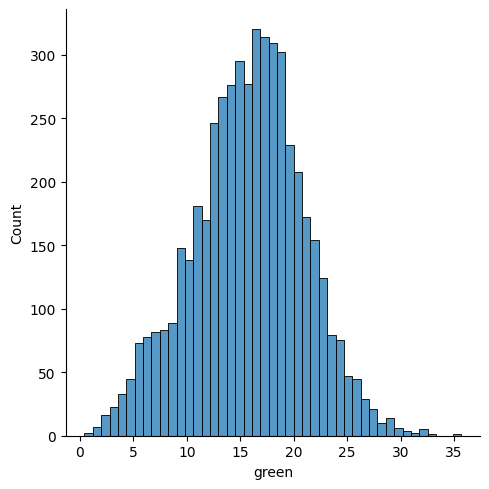

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

standardized = df

standardized['heat'] = np.log(df['heat'])
sns.displot(data=standardized, x='green')

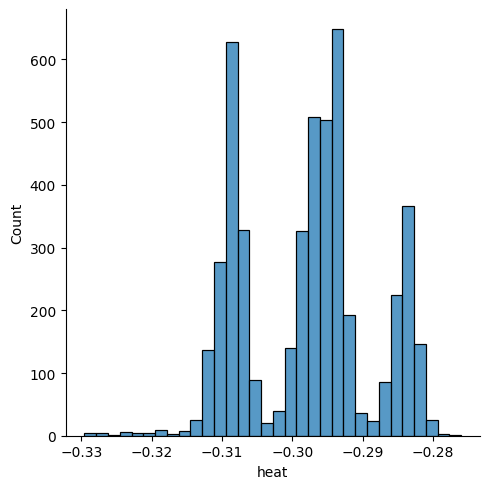

In [64]:
ndf = df[df['heat'] > -0.33]

sns.displot(data=ndf, x="heat")

In [55]:
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split

# Convert data to arrays
X = np.array(ndf["green"]).reshape(-1, 1)
y = np.array(ndf["heat"])

# Remove bad values
mask = np.isfinite(X).flatten() & np.isfinite(y)
X = X[mask]
y = y[mask]

Since the $p$-value is below 0.05 and the coefficient for x1 is negative, it follows that there is a negative correlation between the amount of green space and heat. The goal is to now minimize the MSE by introducing various regresion models of various complexities.

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

for deg in range(10):
    kf = KFold(n_splits=10, shuffle=True)
    res = 0
    for (train_index, test_index) in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Fit OLS model
        poly = PolynomialFeatures(1)
        X_poly = poly.fit_transform(X_train)
        X_polyy = poly.fit_transform(X_test)
        model = LinearRegression()

        results = model.fit(X_poly, y_train)

        y_pred = results.predict(X_polyy)
        res += mean_squared_error(y_test, y_pred)
    print(f"{deg} | Average MSE: {res / 10}")

0 | Average MSE: 8.282550714449358e-05
1 | Average MSE: 8.280225142634433e-05
2 | Average MSE: 8.277898152397641e-05
3 | Average MSE: 8.281519162037836e-05
4 | Average MSE: 8.279182234780407e-05
5 | Average MSE: 8.278772176867771e-05
6 | Average MSE: 8.278195653968557e-05
7 | Average MSE: 8.281030734958415e-05
8 | Average MSE: 8.283631534717644e-05
9 | Average MSE: 8.283028124484846e-05


In [62]:
i = 57
y_pred[i], y_test[i]

(np.float32(-0.2983469), np.float64(-0.2842196552683194))

<Axes: xlabel='green', ylabel='heat'>

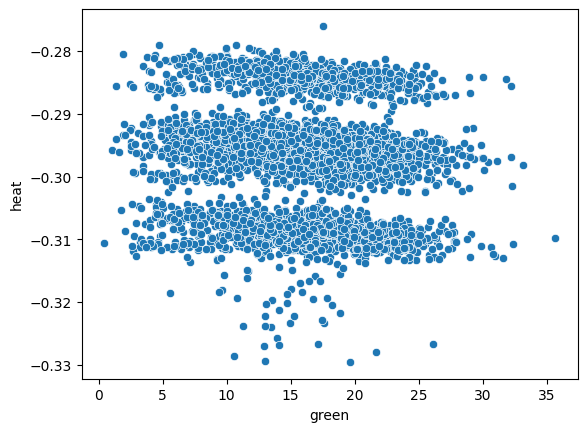

In [57]:
sns.scatterplot(ndf, x="green", y="heat")